**ÉTAPE 0** : préparation des données

In [1]:
import process 
import pandas as pd

# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
# Jerome path : 'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DATA_Statapp.csv'
# Mohamed path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv')

# Apply conversion function to 'open' and 'close' columns
df['open'] = df['open'].apply(process.safe_literal_eval)
df['close'] = df['close'].apply(process.safe_literal_eval)

# Calculate returns for each line
df['return'] = df.apply(lambda row: [(close - open) / open for open, close in zip(row['open'], row['close'])], axis=1)

new_df = df[['ticker', 'return']] # create a new data frame with the column ticker and return 

# Créons le DataFrame à partir des listes dans 'return'
# On suppose ici que 'new_df' est déjà défini et contient la colonne 'return'

# Convertir chaque liste dans la colonne 'return' en plusieurs colonnes dans le nouveau DataFrame
returns_df = pd.DataFrame(new_df['return'].tolist())

# Ajouter la colonne 'ticker' du 'new_df' au début de 'returns_df'
returns_df.insert(0, 'ticker', new_df['ticker'])

# Renommer les colonnes pour refléter qu'elles sont des rendements
returns_df.columns = ['ticker'] + [f'return_{i}' for i in range(len(returns_df.columns) - 1)]

df_cleaned = process.remove_rows_with_nan(returns_df)
df_cleaned.reset_index(drop=True, inplace=True)

process.check_nan_inf(df_cleaned)

df_cleaned.shape

There are no NaN values in the dataframe


(632, 5532)

**ÉTAPE 1** : Phase d'entraînement

1. Obtention de la matrice de corrélation des actifs sur une fenêtre arrière de 30 jours (1 mois)

In [2]:
lookback_window = 30
correlation_matrix = process.correlation_matrix(lookback_window, df_cleaned)

In [4]:
number_of_clusters = 20
result = pd.DataFrame(index=list(correlation_matrix.columns), columns=['Cluster label'], data=process.apply_SPONGE(correlation_matrix, number_of_clusters))
result

/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  A_pos = mat.applymap(lambda x: x if x >= 0 else 0)
/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  A_neg = mat.applymap(lambda x: abs(x) if x < 0 else 0)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Cluster label
AA,18
ABM,13
ABT,12
ADI,14
ADM,8
...,...
XLY,8
XOM,18
XRX,1
YUM,18


Text(0, 0.5, 'Cluster Size')

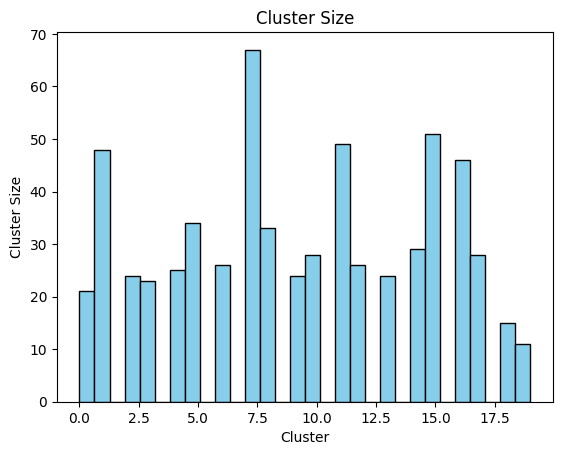

In [29]:
import matplotlib.pyplot as plt

plt.hist(result, bins=30, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Cluster Size')
plt.xlabel('Cluster')
plt.ylabel('Cluster Size')

**ÉTAPE 2** : construction de portefeuille

In [42]:
df_cleaned.set_index('ticker', inplace=True)

In [94]:
cluster_composition = []

for i in range(1, number_of_clusters):

    if i in result['Cluster label'].values: ## we check that the i-th cluster is not empty

        cluster_composition.append([f'cluster {i}', list(result[result['Cluster label'] == i].index)])

In [116]:
import numpy as np 

## we compute the return_centroid of each cluster to attribute intra-cluster weights according to the distance between stocks within the cluster and this 
## centroid

def cluster_composition_and_centroid(df):

    cluster_composition = []

    for i in range(1, number_of_clusters):

        if i in result['Cluster label'].values: ## we check that the i-th cluster is not empty

            cluster_composition.append([f'cluster {i}', list(result[result['Cluster label'] == i].index)])

    number_of_stocks = len(df_cleaned.iloc[0, :].values) ## we first get the total number of stocks we have in our portfolio 

    for i in range(len(cluster_composition)):

        return_centroid = np.zeros(number_of_stocks) ## we prepare the return_centroid array to stock the centroid

        for elem in cluster_composition[i][1]:

            return_centroid = return_centroid + df_cleaned.loc[elem, :].values

        cluster_composition[i].append(return_centroid) ## the third element contains the centroid of the cluster in question

    return cluster_composition

In [117]:
cluster_composition = cluster_composition_and_centroid(df_cleaned)

In [145]:
def constituent_weights(cluster_composition, sigma): ## sigma corresponds to some dispersion cofficient
    
    constituent_weights = []

    for i in range(len(cluster_composition)):

        weights = []

        for elem in cluster_composition[i][1]:

            elem_returns = df_cleaned.loc[elem, :].values

            distance_to_centroid = np.linalg.norm(cluster_composition[i][2] - elem_returns)**2

            weights.append([elem, np.exp(-distance_to_centroid/(2*(sigma**2)))])
        
        constituent_weights.append([cluster_composition[i][0], weights])

    return constituent_weights


In [146]:
constituent_weights = constituent_weights(cluster_composition=cluster_composition, sigma=5)

In [205]:
def cluster_return(constituent_weights, df_cleaned):
    cluster_return = pd.DataFrame(index=None, columns=[f"cluster {i+1}" for i in range(len(constituent_weights))])

    for i in range(len(constituent_weights)):
        res = 0
        for elem in constituent_weights[i][1]:
            res += elem[1]*df_cleaned.loc[elem[0], :].values
        
        cluster_return[f"cluster {i+1}"] = res

    return cluster_return

Le choix des rendements attendus (expected_returns) dans le modèle de Markowitz peut être un défi car il nécessite des prévisions pour chaque actif inclus dans le portefeuille. 

In [206]:
## on récupère le dataframe contenant les return de chaque cluster

cluster_return = cluster_return(constituent_weights=constituent_weights, df_cleaned=df_cleaned) 

## on construit la matrice de corrélation associée à ces returns, c'est donc une matrice de corrélation de return de cluster

cov_matrix = cluster_return.corr(method='pearson')

## on construit le vecteur d'expected return du cluster 
expected_returns = cluster_return.mean(axis=0) ## on fait ici le choix de prendre le rendement moyen comme objectif

## !!! LA FENÊTRE DE 30 JOURS --> PAS 5530 !!

In [215]:
cluster_return

,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14,cluster 15,cluster 16,cluster 17,cluster 18,cluster 19
0,-0.003916,-1.206012e-05,-1.149447e-09,-3.243262e-13,-2.390094e-10,-3.189495e-06,-0.000483,0.030415,-0.000108,-1.661727e-23,-2.569692e-10,-0.000038,-2.624204e-26,0.016385,0.000013,-0.000548,-0.001794,-0.002300,0.008031
1,-0.001972,-1.399414e-05,-2.917476e-09,-1.617835e-13,-5.815658e-11,-1.984405e-06,-0.000774,0.012295,-0.000561,-2.491607e-24,-2.543656e-10,-0.000038,-1.463054e-26,0.103831,-0.000027,0.000357,0.001052,-0.000637,0.002494
2,-0.001007,4.255347e-06,3.786536e-09,1.045364e-13,6.104471e-12,1.504349e-06,-0.000148,0.000669,0.000245,2.825542e-24,-4.453236e-12,0.000026,-1.125874e-27,-0.045667,0.000028,0.000154,0.003016,0.003460,0.011291
3,0.002157,-2.050375e-06,8.185370e-09,1.409293e-13,-5.518844e-11,4.162841e-07,0.000095,-0.014567,0.000039,1.816023e-23,1.955365e-10,0.000034,-4.172411e-27,-0.004408,0.000003,0.000283,-0.000328,0.005910,0.006265
4,-0.000066,1.363914e-05,5.578441e-09,1.335361e-13,1.392485e-10,7.047807e-07,0.000165,0.015102,-0.000101,1.027468e-23,6.217763e-11,0.000002,4.170944e-26,-0.021683,0.000038,0.000264,0.000852,0.007958,0.005879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,0.002229,3.877053e-06,2.564759e-09,1.313502e-13,8.888332e-11,2.165783e-06,0.000188,0.009063,0.000207,6.669544e-24,6.690253e-11,0.000025,1.085184e-26,0.025376,0.000021,0.000358,0.000295,0.004280,-0.001239
5527,0.001067,2.160810e-06,7.361260e-10,7.362058e-14,1.608172e-11,3.958965e-07,0.000055,-0.000709,0.000088,-2.632170e-24,1.662342e-11,0.000006,2.860437e-27,0.019329,0.000005,0.000090,0.000617,0.000925,-0.004077
5528,0.000324,2.151880e-06,8.753316e-10,3.604102e-14,2.534453e-11,4.047564e-07,0.000147,0.003484,0.000092,-3.863334e-24,6.721514e-12,0.000006,4.241108e-27,0.013394,0.000006,0.000106,0.000261,-0.000382,0.000179
5529,-0.000775,-3.217251e-07,6.353169e-11,-7.715083e-14,-2.817443e-11,-1.077624e-06,0.000259,-0.002904,-0.000096,-3.384603e-24,-1.615852e-11,-0.000003,-5.393119e-27,-0.022351,-0.000003,-0.000057,-0.000025,0.002409,0.010259


In [213]:
from pypfopt.efficient_frontier import EfficientFrontier

# Assuming risk_free_rate is the appropriate value for your analysis
risk_free_rate = 0.02

ef = EfficientFrontier(expected_returns, cov_matrix)
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)

ValueError: at least one of the assets must have an expected return exceeding the risk-free rate